[![Open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VVsssssk/mmdeploy-1/blob/add_ipynb/demo/tutorials_1.ipynb)
# 前言
OpenMMLab 的算法如何部署？是很多社区用户的困惑。而模型部署工具箱 [MMDeploy](https://zhuanlan.zhihu.com/p/450342651) 的开源，强势打通了从算法模型到应用程序这 "最后一公里"！
今天我们将开启模型部署入门系列教程，在模型部署开源库 MMDeploy 的辅助下，介绍以下内容：


*   中间表示 ONNX 的定义标准
*   PyTorch 模型转换到 ONNX 模型的方法
*   推理引擎 ONNX Runtime、TensorRT 的使用方法
*   部署流水线 PyTorch - ONNX - ONNX Runtime/TensorRT 的示例及常见部署问题的解决方法
*   MMDeploy C/C++ 推理 SDK
希望通过本系列教程，带领大家学会如何把自己的 PyTorch 模型部署到 ONNX Runtime/TensorRT 上，并学会如何把 OpenMMLab 开源体系中各个计算机视觉任务的模型用 [MMDeploy](https://zhuanlan.zhihu.com/p/450342651) 部署到各个推理引擎上。

**我们默认大家熟悉 Python 语言，并对 PyTorch 框架有基本的认识，除此之外不需要了解任何模型部署的知识。**

在第一篇文章中，我们将部署一个简单的超分辨率模型，认识中间表示、推理引擎等模型部署中的概念。


# 初识模型部署
在软件工程中，部署指把开发完毕的软件投入使用的过程，包括环境配置、软件安装等步骤。类似地，对于深度学习模型来说，模型部署指让训练好的模型在特定环境中运行的过程。相比于软件部署，模型部署会面临更多的难题：

1）运行模型所需的环境难以配置。深度学习模型通常是由一些框架编写，比如 PyTorch、TensorFlow。由于框架规模、依赖环境的限制，这些框架不适合在手机、开发板等生产环境中安装。

2）深度学习模型的结构通常比较庞大，需要大量的算力才能满足实时运行的需求。模型的运行效率需要优化。

因为这些难题的存在，模型部署不能靠简单的环境配置与安装完成。经过工业界和学术界数年的探索，模型部署有了一条流行的流水线：

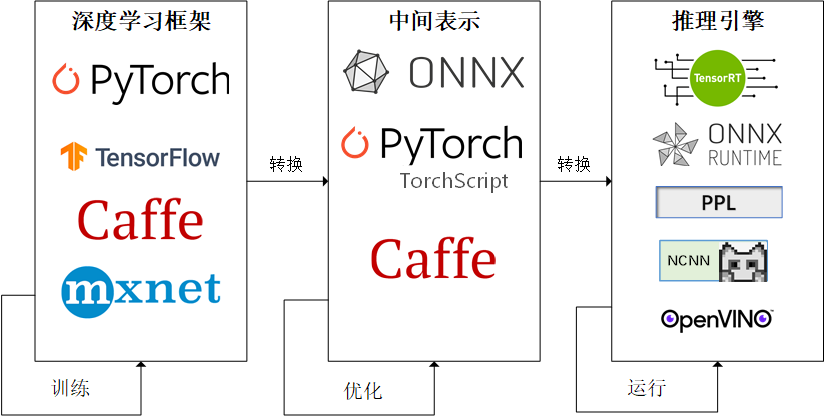

为了让模型最终能够部署到某一环境上，开发者们可以使用任意一种**深度学习框架**来定义网络结构，并通过训练确定网络中的参数。之后，模型的结构和参数会被转换成一种只描述网络结构的**中间表示**，一些针对网络结构的优化会在中间表示上进行。最后，用面向硬件的高性能编程框架(如 CUDA，OpenCL）编写，能高效执行深度学习网络中算子的推理引擎会把中间表示转换成特定的文件格式，并在对应硬件平台上高效运行模型。

这一条流水线解决了模型部署中的两大问题：使用对接深度学习框架和**推理引擎**的中间表示，开发者不必担心如何在新环境中运行各个复杂的框架；通过中间表示的网络结构优化和推理引擎对运算的底层优化，模型的运算效率大幅提升。

现在，让我们从一个模型部署的“Hello World”项目入手，见识一下模型部署各方面的知识吧！

# 部署第一个模型
## 创建 PyTorch 模型
让我们用 PyTorch 实现一个超分辨率模型，并把模型部署到 ONNX Runtime 这个推理引擎上。

首先，我们需要创建一个有 PyTorch 库的 Python 编程环境。

In [ ]:
# 检查nvcc版本
!nvcc -V
# 检查gcc版本
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# 安装 cuda 11.1 的 PyTorch 
# 如果你用的是其他版本的 cuda，请参考 PyTorch 的官方安装教程选择安装命令 
!pip install torch==1.8.2+cu111 torchvision==0.9.2+cu111 torchaudio==0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
# 安装 ONNX Runtime, ONNX, OpenCV 
!pip install onnxruntime==1.8.1 onnx opencv-python

Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
     |█████████████▌                  | 834.1 MB 1.6 MB/s eta 0:11:43tcmalloc: large alloc 1147494400 bytes == 0x5613cfd9a000 @  0x7f1182a1e615 0x5613964f13bc 0x5613965d218a 0x5613964f41cd 0x5613965e6b3d 0x561396568458 0x56139656302f 0x5613964f5aba 0x5613965682c0 0x56139656302f 0x5613964f5aba 0x561396564cd4 0x5613965e7986 0x561396564350 0x5613965e7986 0x561396564350 0x5613965e7986 0x561396564350 0x5613964f5f19 0x561396539a79 0x5613964f4b32 0x5613965681dd 0x56139656302f 0x5613964f5aba 0x561396564cd4 0x56139656302f 0x5613964f5aba 0x561396563eae 0x5613964f59da 0x561396564108 0x56139656302f
     |█████████████████               | 1055.7 MB 1.4 MB/s eta 0:11:10tcmalloc: large alloc 1434370048 bytes == 0x5614143f0000 @  0x7f1182a1e615 0x5613964f13bc 0x5613965d218a 0x5613964f41cd 0x5613965e6b3d 0x561396568458 0x56139656302f 0x5613964f5aba 0x5613965682c0 0x56139656302f 0x5613964f5aba 0x561396564cd4 0x5613965e7986 0x56139

在一切都配置完毕后，用下面的代码来创建一个经典的超分辨率模型 SRCNN。

In [ ]:
import os 
 
import cv2 
import numpy as np 
import requests 
import torch 
import torch.onnx 
from torch import nn 
 
class SuperResolutionNet(nn.Module): 
    def __init__(self, upscale_factor): 
        super().__init__() 
        self.upscale_factor = upscale_factor 
        self.img_upsampler = nn.Upsample( 
            scale_factor=self.upscale_factor, 
            mode='bicubic', 
            align_corners=False) 
 
        self.conv1 = nn.Conv2d(3,64,kernel_size=9,padding=4) 
        self.conv2 = nn.Conv2d(64,32,kernel_size=1,padding=0) 
        self.conv3 = nn.Conv2d(32,3,kernel_size=5,padding=2) 
 
        self.relu = nn.ReLU() 
 
    def forward(self, x): 
        x = self.img_upsampler(x) 
        out = self.relu(self.conv1(x)) 
        out = self.relu(self.conv2(out)) 
        out = self.conv3(out) 
        return out 
 
# Download checkpoint and test image 
urls = ['https://download.openmmlab.com/mmediting/restorers/srcnn/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth', 
    'https://raw.githubusercontent.com/open-mmlab/mmediting/master/tests/data/face/000001.png'] 
names = ['srcnn.pth', 'face.png'] 
for url, name in zip(urls, names): 
    if not os.path.exists(name): 
        open(name, 'wb').write(requests.get(url).content) 
 
def init_torch_model(): 
    torch_model = SuperResolutionNet(upscale_factor=3) 
 
    state_dict = torch.load('srcnn.pth')['state_dict'] 
 
    # Adapt the checkpoint 
    for old_key in list(state_dict.keys()): 
        new_key = '.'.join(old_key.split('.')[1:]) 
        state_dict[new_key] = state_dict.pop(old_key) 
 
    torch_model.load_state_dict(state_dict) 
    torch_model.eval() 
    return torch_model 
 
model = init_torch_model() 
input_img = cv2.imread('face.png').astype(np.float32) 
 
# HWC to NCHW 
input_img = np.transpose(input_img, [2, 0, 1]) 
input_img = np.expand_dims(input_img, 0) 
 
# Inference 
torch_output = model(torch.from_numpy(input_img)).detach().numpy() 
 
# NCHW to HWC 
torch_output = np.squeeze(torch_output, 0) 
torch_output = np.clip(torch_output, 0, 255) 
torch_output = np.transpose(torch_output, [1, 2, 0]).astype(np.uint8) 
 
# Show image 
cv2.imwrite("face_torch.png", torch_output)

True

SRCNN 先把图像上采样到对应分辨率，再用 3 个卷积层处理图像。为了方便起见，我们跳过训练网络的步骤，直接下载模型权重（由于 MMEditing 中 SRCNN 的权重结构和我们定义的模型不太一样，我们修改了权重字典的 key 来适配我们定义的模型），同时下载好输入图片。为了让模型输出成正确的图片格式，我们把模型的输出转换成 HWC 格式，并保证每一通道的颜色值都在 0~255 之间。如果脚本正常运行的话，一幅超分辨率的人脸照片会保存在 “face_torch.png” 中。

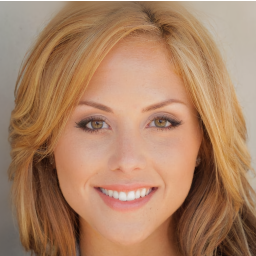

在 PyTorch 模型测试正确后，我们来正式开始部署这个模型。我们下一步的任务是把 PyTorch 模型转换成用中间表示 ONNX 描述的模型。
## 中间表示 - ONNX
在介绍 ONNX 之前，我们先从本质上来认识一下神经网络的结构。神经网络实际上只是描述了数据计算的过程，其结构可以用计算图表示。比如 a+b 可以用下面的计算图来表示：

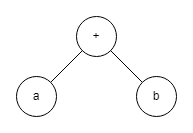

为了加速计算，一些框架会使用对神经网络“先编译，后执行”的静态图来描述网络。静态图的缺点是难以描述控制流（比如 if-else 分支语句和 for 循环语句），直接对其引入控制语句会导致产生不同的计算图。比如循环执行 n 次 a=a+b，对于不同的 n，会生成不同的计算图：

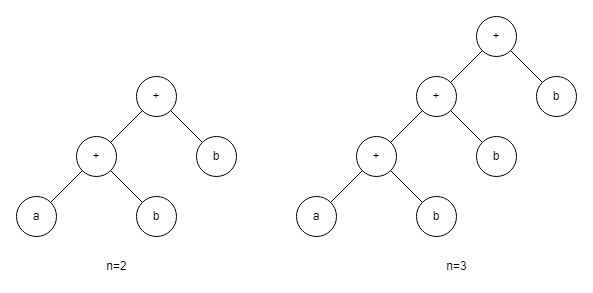

ONNX （Open Neural Network Exchange）是 Facebook 和微软在2017年共同发布的，用于标准描述计算图的一种格式。目前，在数家机构的共同维护下，ONNX 已经对接了多种深度学习框架和多种推理引擎。因此，ONNX 被当成了深度学习框架到推理引擎的桥梁，就像编译器的中间语言一样。由于各框架兼容性不一，我们通常只用 ONNX 表示更容易部署的静态图。

让我们用下面的代码来把 PyTorch 的模型转换成 ONNX 格式的模型：

In [ ]:
x = torch.randn(1, 3, 256, 256) 
 
with torch.no_grad(): 
    torch.onnx.export( 
        model, 
        x, 
        "srcnn.onnx", 
        opset_version=11, 
        input_names=['input'], 
        output_names=['output'])

其中，**torch.onnx.export** 是 PyTorch 自带的把模型转换成 ONNX 格式的函数。让我们先看一下前三个必选参数：前三个参数分别是要转换的模型、模型的任意一组输入、导出的 ONNX 文件的文件名。转换模型时，需要原模型和输出文件名是很容易理解的，但为什么需要为模型提供一组输入呢？这就涉及到 ONNX 转换的原理了。从 PyTorch 的模型到 ONNX 的模型，本质上是一种语言上的翻译。直觉上的想法是像编译器一样彻底解析原模型的代码，记录所有控制流。但前面也讲到，我们通常只用 ONNX 记录不考虑控制流的静态图。因此，PyTorch 提供了一种叫做追踪（trace）的模型转换方法：给定一组输入，再实际执行一遍模型，即把这组输入对应的计算图记录下来，保存为 ONNX 格式。export 函数用的就是追踪导出方法，需要给任意一组输入，让模型跑起来。我们的测试图片是三通道，256x256大小的，这里也构造一个同样形状的随机张量。

剩下的参数中，opset_version 表示 ONNX 算子集的版本。深度学习的发展会不断诞生新算子，为了支持这些新增的算子，ONNX会经常发布新的算子集，目前已经更新15个版本。我们令 opset_version = 11，即使用第11个 ONNX 算子集，是因为 SRCNN 中的 bicubic （双三次插值）在 opset11 中才得到支持。剩下的两个参数 input_names, output_names 是输入、输出 tensor 的名称，我们稍后会用到这些名称。

如果上述代码运行成功，目录下会新增一个"srcnn.onnx"的 ONNX 模型文件。我们可以用下面的脚本来验证一下模型文件是否正确。

In [ ]:
import onnx 
 
onnx_model = onnx.load("srcnn.onnx") 
try: 
    onnx.checker.check_model(onnx_model) 
except Exception: 
    print("Model incorrect") 
else: 
    print("Model correct")

Model correct


其中，**onnx.load** 函数用于读取一个 ONNX 模型。**onnx.checker.check_model** 用于检查模型格式是否正确，如果有错误的话该函数会直接报错。我们的模型是正确的，控制台中应该会打印出"Model correct"。

接下来，让我们来看一看 ONNX 模型具体的结构是怎么样的。我们可以使用 **Netron** （开源的模型可视化工具）来可视化 ONNX 模型。把 srcnn.onnx 文件从本地的文件系统拖入网站，即可看到如下的可视化结果：

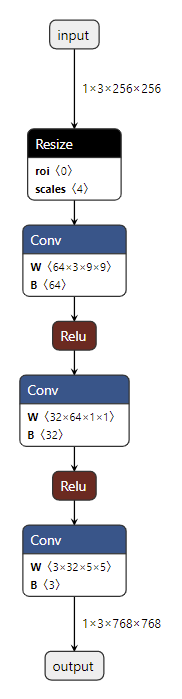

点击 input 或者 output，可以查看 ONNX 模型的基本信息，包括模型的版本信息，以及模型输入、输出的名称和数据类型。

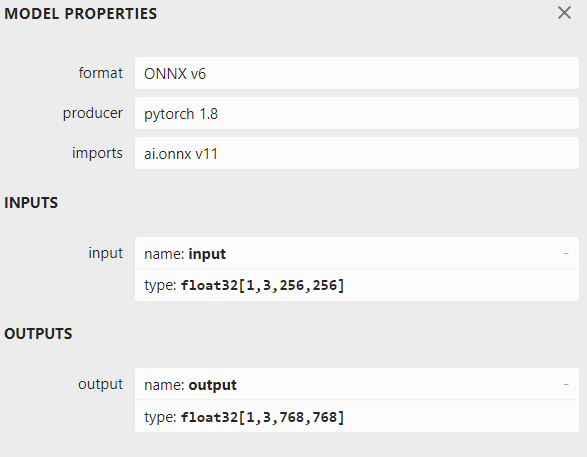

点击某一个算子节点，可以看到算子的具体信息。比如点击第一个 Conv 可以看到：

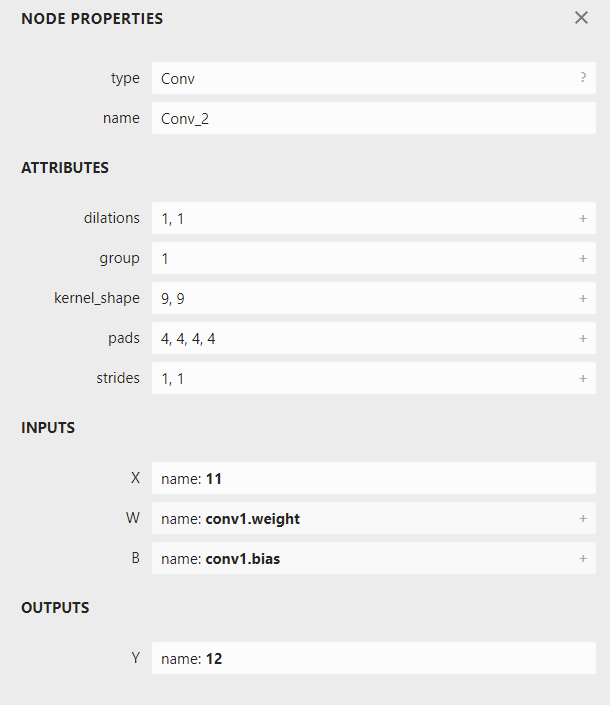

每个算子记录了算子属性、图结构、权重三类信息。

*   算子属性信息即图中 attributes 里的信息，对于卷积来说，算子属性包括了卷积核大小(kernel_shape)、卷积步长(strides)等内容。这些算子属性最终会用来生成一个具体的算子。
*   图结构信息指算子节点在计算图中的名称、邻边的信息。对于图中的卷积来说，该算子节点叫做 Conv_2，输入数据叫做 11，输出数据叫做 12。根据每个算子节点的图结构信息，就能完整地复原出网络的计算图。
*   权重信息指的是网络经过训练后，算子存储的权重信息。对于卷积来说，权重信息包括卷积核的权重值和卷积后的偏差值。点击图中 conv1.weight, conv1.bias 后面的加号即可看到权重信息的具体内容。
现在，我们有了 SRCNN 的 ONNX 模型。让我们看看最后该如何把这个模型运行起来。

## 推理引擎 -ONNX Runtime
**ONNX Runtime** 是由微软维护的一个跨平台机器学习推理加速器，也就是我们前面提到的”推理引擎“。ONNX Runtime 是直接对接 ONNX 的，即 ONNX Runtime 可以直接读取并运行 .onnx 文件, 而不需要再把 .onnx 格式的文件转换成其他格式的文件。也就是说，对于 PyTorch - ONNX - ONNX Runtime 这条部署流水线，只要在目标设备中得到 .onnx 文件，并在 ONNX Runtime 上运行模型，模型部署就算大功告成了。

通过刚刚的操作，我们把 PyTorch 编写的模型转换成了 ONNX 模型，并通过可视化检查了模型的正确性。最后，让我们用 ONNX Runtime 运行一下模型，完成模型部署的最后一步。

ONNX Runtime 提供了 Python 接口。接着刚才的脚本，我们可以添加如下代码运行模型：

In [ ]:
import onnxruntime 
 
ort_session = onnxruntime.InferenceSession("srcnn.onnx") 
ort_inputs = {'input': input_img} 
ort_output = ort_session.run(['output'], ort_inputs)[0] 
 
ort_output = np.squeeze(ort_output, 0) 
ort_output = np.clip(ort_output, 0, 255) 
ort_output = np.transpose(ort_output, [1, 2, 0]).astype(np.uint8) 
cv2.imwrite("face_ort.png", ort_output)

这段代码中，除去后处理操作外，和 ONNX Runtime 相关的代码只有三行。让我们简单解析一下这三行代码。**onnxruntime.InferenceSession** 用于获取一个 ONNX Runtime 推理器，其参数是用于推理的 ONNX 模型文件。推理器的 run 方法用于模型推理，其第一个参数为输出张量名的列表，第二个参数为输入值的字典。其中输入值字典的 key 为张量名，value 为 numpy 类型的张量值。输入输出张量的名称需要和 **torch.onnx.export** 中设置的输入输出名对应。

如果代码正常运行的话，另一幅超分辨率照片会保存在"face_ort.png"中。这幅图片和刚刚得到的"face_torch.png"是一模一样的。这说明 ONNX Runtime 成功运行了 SRCNN 模型，模型部署完成了！以后有用户想实现超分辨率的操作，我们只需要提供一个 "srcnn.onnx" 文件，并帮助用户配置好 ONNX Runtime 的 Python 环境，用几行代码就可以运行模型了。或者还有更简便的方法，我们可以利用 ONNX Runtime 编译出一个可以直接执行模型的应用程序。我们只需要给用户提供 ONNX 模型文件，并让用户在应用程序选择要执行的 ONNX 模型文件名就可以运行模型了。

# 总结
在这篇教程里，我们利用成熟的模型部署工具，轻松部署了一个初始版本的超分辨率模型 SRCNN。但在实际应用场景中，随着模型结构的复杂度不断加深，碰到的困难的也会越来越多。在下一篇教程里，我们将“升级”一下这个超分辨率模型，让它支持动态的输入。

看完这篇教程，是不是感觉知识太多一下消化不过来？没关系，模型部署本身有非常多的东西要学。为了举例的方便，这篇教程包含了许多未来才会讲到的知识点。事实上，读完这篇教程后，记下以下知识点就够了：

*   模型部署，指把训练好的模型在特定环境中运行的过程。模型部署要解决模型框架兼容性差和模型运行速度慢这两大问题。
*   模型部署的常见流水线是“深度学习框架-中间表示-推理引擎”。其中比较常用的一个中间表示是 ONNX。
*   深度学习模型实际上就是一个计算图。模型部署时通常把模型转换成静态的计算图，即没有控制流（分支语句、循环语句）的计算图。
*   PyTorch 框架自带对 ONNX 的支持，只需要构造一组随机的输入，并对模型调用 **torch.onnx.export** 即可完成 PyTorch 到 ONNX 的转换。
*   推理引擎 ONNX Runtime 对 ONNX 模型有原生的支持。给定一个 .onnx 文件，只需要简单使用 ONNX Runtime 的 Python API 就可以完成模型推理。

为了实现深度学习算法的落地，充满挑战的模型部署是一个逃不开的步骤。为此，我们开发的开源库 MMDeploy 实现了 OpenMMLab 中目标检测、图像分割、超分辨率等多个视觉任务模型的部署，支持 ONNX Runtime，TensorRT，ncnn ，openppl，OpenVINO 等多个推理引擎。在后续的模型部署教程中，我们将在介绍模型部署技术的同时，介绍这些技术是如何运用在 MMDeploy 中的。希望大家继续关注我们的后续教程，关注 MMDeploy，共同为深度学习算法落地贡献自己的一份力。